In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import datetime
from datetime import datetime
from utils import helper as hp
from utils.config_util import Config
from PIL import ImageFile
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
all_athletes = pd.read_csv('csvs/athlete_athletes_comlete.csv')
alternate_atheletes = pd.read_csv('csvs/alternate_athlete_athletes_comlete.csv')
na_athlete = pd.read_csv('csvs/na_athlete_athletes_comlete.csv')

now = datetime.now()
all_athletes['dob'] = pd.to_datetime(all_athletes['dob'])
all_athletes['age'] = all_athletes['dob'].apply(lambda x: now.year - x.year - ((now.month, now.day) < (x.month, x.day)))

code_2_disciplines = pd.read_csv('csvs/athletes_disciplines_complete.csv')

athletes_disciplines = pd.merge(all_athletes, code_2_disciplines, on='code')
athletes_disciplines.to_csv('csvs/everything.csv', index=False)

## How many athletes are there in the dataset?

In [3]:
len(all_athletes)

10929

## How many men and women are there

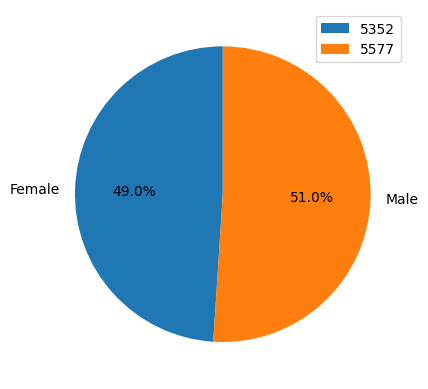

In [4]:
all_athletes.groupby('gender').code.count().plot(kind='pie', autopct='%1.1f%%', startangle=90, shadow=False)
plt.legend(all_athletes.groupby('gender').code.count())
plt.ylabel('')
plt.show()

## How many people born in each month

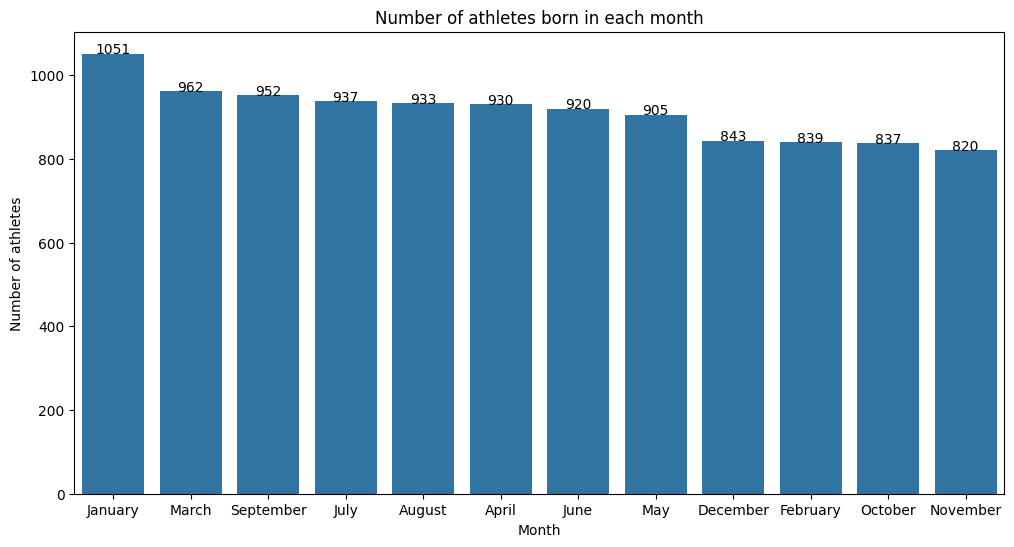

In [5]:
all_athletes['month'] = all_athletes['dob'].dt.month

def month_number_to_month_name(month_num: int) -> str:
    months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
    return months[month_num]

all_athletes['month'] = all_athletes['month'].apply(month_number_to_month_name)

all_athletes.groupby('month').code.count()

# bar plot with value counts of athletes born in each month, showing number on top of each bar

plt.figure(figsize=(12, 6))
sns.barplot(x=all_athletes['month'].value_counts().index, y=all_athletes['month'].value_counts().values)
for i in range(len(all_athletes['month'].value_counts().values)):
    plt.text(i, all_athletes['month'].value_counts().values[i], all_athletes['month'].value_counts().values[i], ha = 'center')
    
plt.title('Number of athletes born in each month')
plt.ylabel('Number of athletes')
plt.xlabel('Month')
plt.show()


# Most Senior and Junior athletes

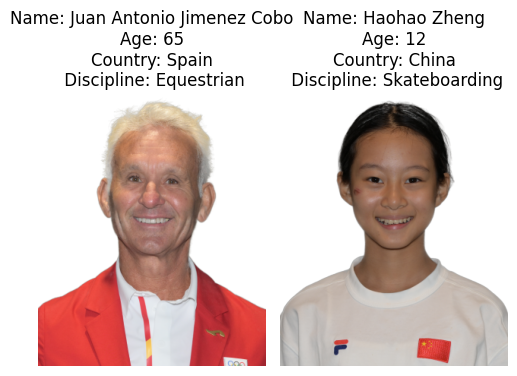

In [6]:
senior = all_athletes['dob'].idxmin()
junior = all_athletes['dob'].idxmax()
needed_columns = ['code', 'given_name', 'family_name', 'noc_full', 'dob', 'age', 'picture_url', 'detail_url']
G = pd.concat([all_athletes.loc[senior], all_athletes.loc[junior]], axis=1).T.copy().reset_index(drop=True)
G = G[needed_columns]


fig, axes = plt.subplots(1, 2, figsize=(5, 5))

for i in range(2):
    row = G.loc[i]
    disciplines = code_2_disciplines[code_2_disciplines['code'] == G.loc[i, 'code']]['discipline_desc'].values
    axes[i].axis('off')
    axes[i].imshow(hp.fetch_image(row['picture_url'], row['code']))
    axes[i].set_title(f"Name: {row['given_name']} {row['family_name']}\nAge: {row['age']}\nCountry: {row['noc_full']}\n Discipline: {disciplines[0]}")

plt.tight_layout()
plt.show()


## Thai Athletes Overview

In [7]:
def show_thai():
    thai_athletes = all_athletes[all_athletes['noc_full'] == 'Thailand']
    len(thai_athletes)
    thai_athletes = thai_athletes.sort_values('age')
    fig, axes = plt.subplots(5, 11, figsize=(50, 50))

    tables = list(thai_athletes[needed_columns].iterrows())
    in_ = 0 
    for i in range(5):
        for j in range(11):
            axes[i, j].axis('off')
            if in_ < len(tables):
                index, profile = tables[in_]
                code, given_name, family_name, noc_full, dob, age, picture_url, detail_url = profile
                discipline = code_2_disciplines[code_2_disciplines['code'] == code]['discipline_desc'].values[0]
                image = hp.fetch_image(picture_url, code)
                axes[i, j].imshow(image)
                in_ += 1
                axes[i, j].set_title(f"{given_name}\n{family_name.upper()}\n({age})\n{discipline}\n\n", fontsize=30)
    plt.tight_layout()
    plt.show()
# show_thai()

## Check medals won by Country

In [8]:

config = Config('configs/url_config.yaml')
URLS_CONFIG = config.config['URLS']

def medals_won_by_noc(medal_tables: list, country_code: str) -> tuple:
    
    """
    Function to get the medals won by a country
    """
   
    try:
        medal_tbl_by_cntry = [m for m in medal_tables if m['organisation'] == country_code][0]
        disciplines_won_lst = medal_tbl_by_cntry['disciplines']
    except Exception as e:
        print(f"Error: {e}")
        print('Make sure the country code is correct ')
        raise Exception('Make sure the country code is correct')
    return medal_tbl_by_cntry, disciplines_won_lst


def rework_the_team_profile(disciplines_won_list):
    all_objects = []
    for discipline_won in disciplines_won_list:
        athlete_won_obj = dict()
        discipline_name = discipline_won['name']
        athlete_won_obj['n'] = discipline_name
        
        info_list = [] 
        for winner in discipline_won['medalWinners']:
            info = dict()
            info['medalType'] = winner['medalType'].split('_')[1].lower()
            info['type'] = 'individual' if winner['competitorType'] == 'A' else 'team'
            info['code'] = winner['competitorCode']
            info_list.append(info)
        athlete_won_obj['winnerInfo'] = info_list
        all_objects.append(athlete_won_obj)
    return all_objects

def expend_team_profile(config, result_obj_list: list):
    rt_obj = result_obj_list.copy()
    TEAM_PROFILE_URL = config['TEAM_PROFILE_URL']
    for i in rt_obj:
        i['winnerInfo_WIP'] = []
        for each_winner_in_discipline in i['winnerInfo']:
            # prepare for teams expansion
            
            if each_winner_in_discipline['type'] == 'team':
                
                file_name = f'jsons/team_profile_{each_winner_in_discipline["code"]}.json'
                if os.path.exists(file_name) and os.path.getsize(file_name) > 0:
                    team_profile = hp.load_json(file_name)
                else:
                    team_profile = hp.fetch_json(TEAM_PROFILE_URL.format(code=each_winner_in_discipline['code']))
                    hp.save_json(team_profile, file_name)
                
                team_profile_list = team_profile['team']['athletes']
            
                for athlete in team_profile_list:                        
                    info = dict()
                    info['code'] = athlete['person']['code']
                    
                    info['medalType'] = each_winner_in_discipline['medalType']
                    info['type'] = 'individual_expanded'
                    i['winnerInfo_WIP'].append(info)
                    
        if i['winnerInfo_WIP']:
            individual_list = [obj for obj in i['winnerInfo'] if obj['type'] == 'individual']
            i['winnerInfo_WIP'].extend(individual_list)
            i['winnerInfo'] = i['winnerInfo_WIP'].copy()
            del i['winnerInfo_WIP'] 
    return rt_obj


def make_code_2_winners_obj(expanded_result_object_list: list, athletes_dfs: list):
    # convert type of code column to string
    combined_athletes = pd.concat(athletes_dfs, ignore_index=True)
    combined_athletes['code'] = combined_athletes['code'].astype(str)

    code_2_medal = dict()
    
    for _discipline in expanded_result_object_list:
        discipline_name = _discipline['n']
        for winner in _discipline['winnerInfo']:
            code = winner['code']
            if code not in code_2_medal:
                code_2_medal[code] = []
            code_2_medal[code].append({'discipline': discipline_name, 'medal': winner['medalType']})

            try:
                athlete = combined_athletes[combined_athletes['code'] == code].iloc[0]
            except:
                print(f'Ignoring this athlete {code} due to technical issues') 
                continue
            if athlete['mainfunc_desc'] == 'alternate athlete':
                code_2_medal[code].append('alternate_flag')
    return code_2_medal
    
def load_medal_images():
    medal_size = (50, 50)
    medal_images = dict()
    for medal in ['gold', 'silver', 'bronze']:
        medal_images[medal] = Image.open(f'images/medals/{medal}.png').convert('RGBA').resize(medal_size)
    return medal_images

def build_medal_presentation_png(code_2_medal_lst, col_num, athletes_dfs):
    combined_athletes = pd.concat(athletes_dfs, ignore_index=True)
    combined_athletes['code'] = combined_athletes['code'].astype(str)
    now = datetime.now()

    combined_athletes['dob'] = pd.to_datetime(combined_athletes['dob'], errors='coerce')
    combined_athletes['dob'] = combined_athletes['dob'].fillna(pd.to_datetime('1900-01-01'))
    

    combined_athletes['age'] = combined_athletes['dob'].apply(lambda x: now.year - x.year - ((now.month, now.day) < (x.month, x.day)))
    combined_athletes['age'] = combined_athletes['age'].astype(int)
    
    
    needed_columns = ['code', 'given_name', 'family_name', 'noc_full', 'dob', 'age', 'picture_url', 'detail_url']
    medal_images = load_medal_images()
    num_rows = len(code_2_medal_lst)//col_num + 1
    
    selected_df = combined_athletes[combined_athletes['code'].isin(code_2_medal_lst.keys())][needed_columns]    
    for row in range(num_rows):
        df_slice = selected_df.iloc[row*col_num: (row+1)*col_num]
        df_slice = df_slice.reset_index(drop=True)
        if df_slice.empty:
            break
        fig, axes = plt.subplots(1, col_num, figsize=(50, 50))
        
        for index, data in df_slice.iterrows():
            code, given_name, family_name, noc_full, dob, age, picture_url, detail_url = data
            medals_list = code_2_medal_lst[code] # [{discipline: 'discipline_name', medal: 'medal_type'}]
            
            alternate_flag = False
            if medals_list[-1] == 'alternate_flag':
                alternate_flag = True
                medals_list.pop()
            
            image = hp.fetch_image(data['picture_url'], code)
            
            move_right = 0
            move_down = 0
            
            
            disciplines_set = set()
            medal_c = 1
            for medals_for_this_code in medals_list:
                
                
                # there is no more room for medals in the image, move down and reset move_right
                if medal_c > 4:
                    print('nore more room')
                    move_right = 0
                    move_down += 60
                
                discipline, medal = medals_for_this_code.values()
                disciplines_set.add(discipline)
                image = hp.add_medal(image, medal_images[medal], (move_right, move_down))
                move_right += 60
                medal_c += 1
                
            disciplines = ', '.join(disciplines_set)
            axes[index%col_num].axis('off')
            axes[index%col_num].imshow(image)
            axes[index%col_num].set_title(f"{given_name}\n{family_name.upper()}\n({age})\n{discipline}\n{'alternate' if alternate_flag else ''}", fontsize=30)
        
        
        full_row = index%col_num == col_num -1 
        if not full_row:
            for i in range(index%col_num+1, col_num):    
                fig.delaxes(axes[i])
            fig.set_size_inches(50, 50*(index%col_num+1)/col_num)
        plt.tight_layout()
        plt.show()

def countries_won_medals(config):
    
    MEDALS_URL = config['MEDAL_URL']
    medals_json = hp.fetch_json(MEDALS_URL)
    hp.save_json(medals_json, 'jsons/medals.json')
    medal_tables = medals_json['medalStandings']['medalsTable']
    return [m['organisation'] for m in medal_tables], medal_tables


def pipeline_make_medal_from_country_code(config, country_choice, medal_tables, athletes_dfs):
    _, disciplines_won_list = medals_won_by_noc(medal_tables, country_choice)
    result_obj = rework_the_team_profile(disciplines_won_list)
    rs_obj = expend_team_profile(config, result_obj)
    return make_code_2_winners_obj(rs_obj, athletes_dfs)

nocs_df = pd.read_csv('csvs/noc.csv')
countries_won, medal_tables = countries_won_medals(URLS_CONFIG)
countrycode_countryname = [(nocs_df[nocs_df['noc_code'] == c]['noc_name'].values[0], c) for c in countries_won]
countrycode_countryname = sorted(countrycode_countryname, key=lambda x: x[0])
Country_Dropdown = widgets.Dropdown(
    options=countrycode_countryname,
    value='THA',
    description='Country:' ,
    disabled=False,
    
)
print('Only show countries that won medals')
display(Country_Dropdown)





Only show countries that won medals


Dropdown(description='Country:', index=83, options=(('Albania', 'ALB'), ('Algeria', 'ALG'), ('Argentina', 'ARG…

Building the presentation
Selected country: THA


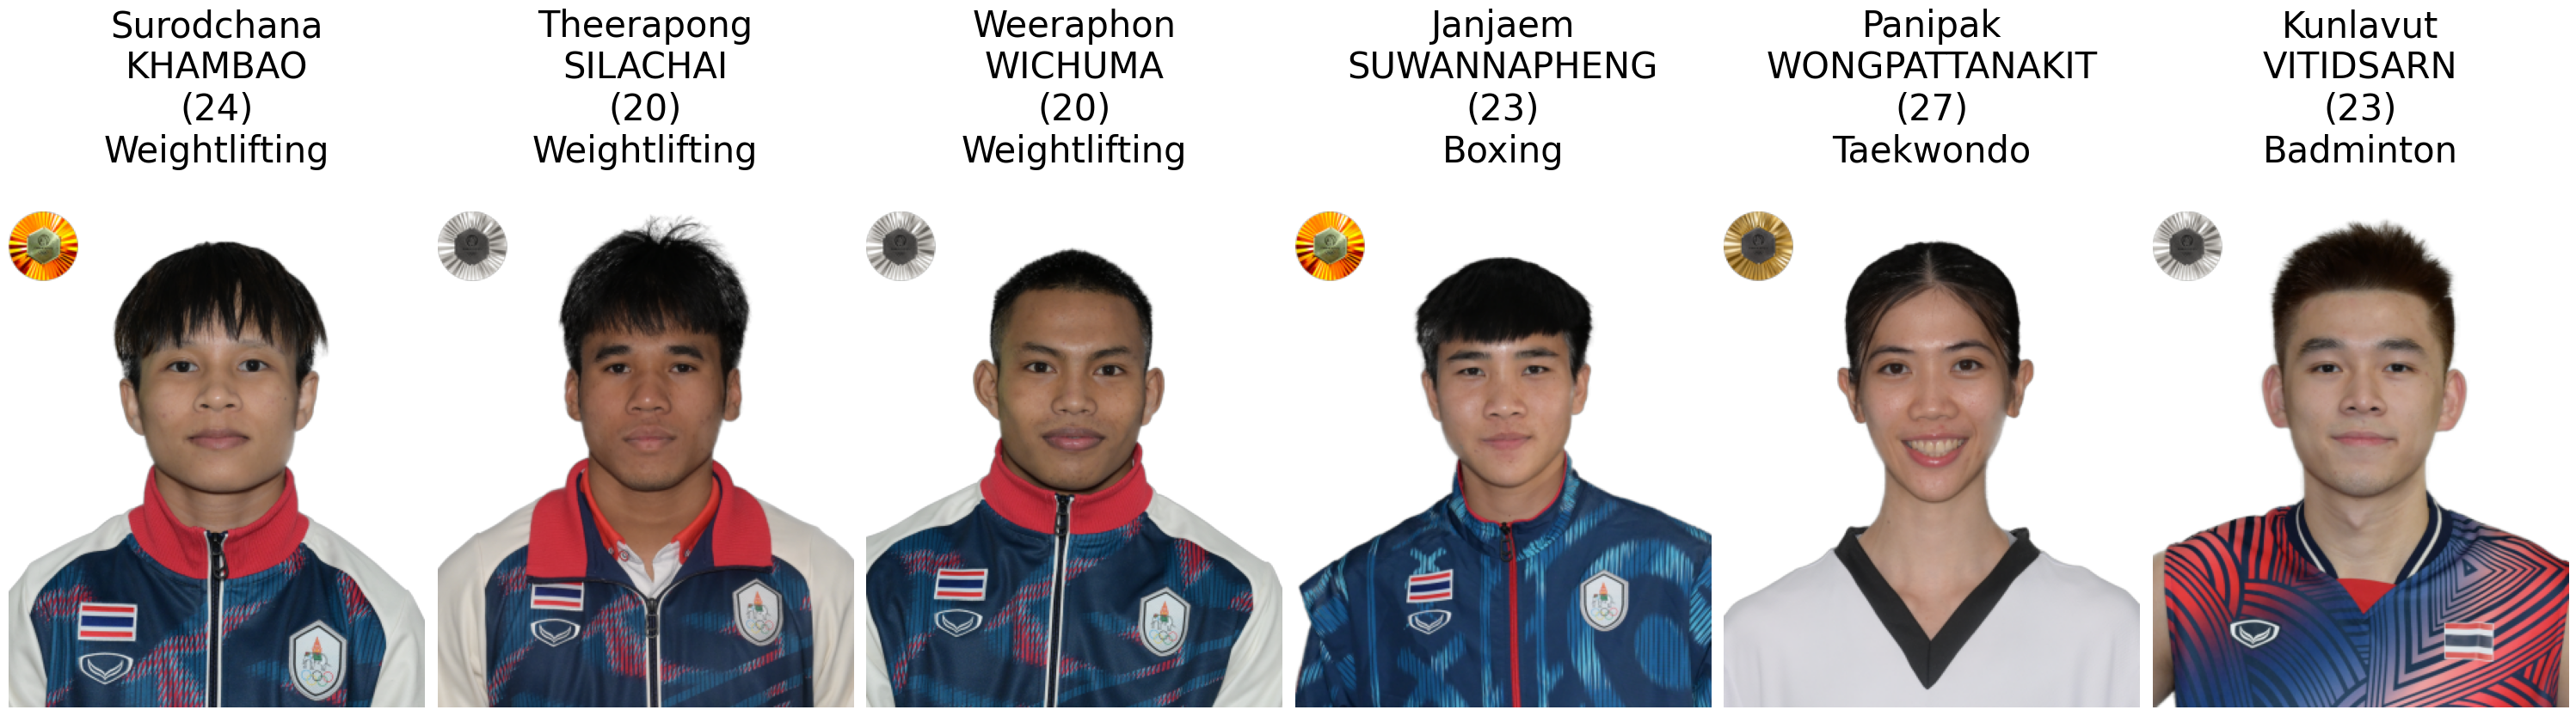

In [9]:
print('Building the presentation')
print('Selected country:', Country_Dropdown.value)
to_combine_df = [all_athletes, alternate_atheletes, na_athlete]
code_2_medal_list = pipeline_make_medal_from_country_code(URLS_CONFIG, Country_Dropdown.value, medal_tables, to_combine_df)
build_medal_presentation_png(code_2_medal_list, 10, to_combine_df)

## Atheletes who won the highest number of medals

In [10]:
countries, medal_tables =  countries_won_medals(URLS_CONFIG)
tally = []
for i in medal_tables:
    a = i['disciplines']
    for j in a:
        m = j['medalWinners']
        for l in m:
            r = dict()
            r['medalType'] = l['medalType']
            r['competitorCode'] = l['competitorCode']
            r['competitorType'] = l['competitorType']
            tally.append(r)

    
new_tally = []
for i in tally:
    if i['competitorType'] == 'A':
        new_tally.append(i)
    else:
        new_tally.extend(hp.get_team_members(URLS_CONFIG, i))
        

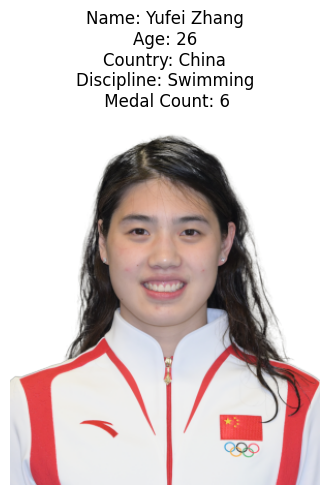

In [11]:
medalist_df = pd.DataFrame(new_tally, columns=[ 'competitorCode', 'medalType'])
f = medalist_df.groupby('competitorCode')['medalType'].count().sort_values(ascending=False)
code = int(f.index[0])
medal_count = f.values[0]
hp.search_and_show(code, to_combine_df, code_2_disciplines, medal_count)
